Creating Business Pandas
Creating Review Pandas
Completed Creating Pandas


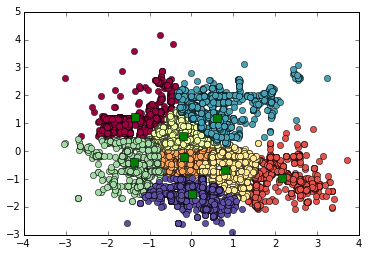

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt
import os
import json
import pprint
from boto.s3.connection import S3Connection
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import pylab as pl
import numpy as np


%matplotlib inline

# Limit rows disp# Limit rows displayed in notebook
pd.set_option('display.max_rows', 20)
pd.set_option('display.precision', 2)

import json
import pandas as pd
 
def convertBusiness(x):
    ob = json.loads(x)
    for k, v in ob.items():
        if isinstance(v, list):
            ob[k] = ','.join(v)
        elif isinstance(v, dict):
            for kk, vv in v.items():
                ob['%s_%s' % (k, kk)] = vv
            del ob[k]
    return ob

def convertReviews(x):
    ''' Convert a json string to a flat python dictionary
    which can be passed into Pandas. '''
    ob = json.loads(x)
    return {"business_id":ob["business_id"], "stars":ob["stars"], "date":ob["date"]}

def createPandas(func, json_filename):
    return pd.DataFrame([func(line) for line in file(json_filename)])

print "Creating Business Pandas"
pd_business = createPandas(convertBusiness,'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_business.json')
print "Creating Review Pandas"
pd_review = createPandas(convertReviews, 'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json')
print "Completed Creating Pandas"

pd_business_lasvegas = pd_business[pd_business["city"] == "Las Vegas"]
pd_review_lasvegas = pd.merge(pd_business_lasvegas, pd_review, left_on='business_id', right_on='business_id', how='inner')

''' K Means with results '''

from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,kmeans2, vq

business_lasvegas_latlong = pd_business_lasvegas[["latitude", "longitude"]].values.tolist()
X = StandardScaler().fit_transform(business_lasvegas_latlong)

k = 8
centroids, labels = kmeans2(X,k)
idx,_ = vq(X,centroids)
colors = pl.cm.Spectral(np.linspace(0, 1, k))
for i in range(k):
    plot(X[idx==i,0],X[idx==i,1], 'o', markerfacecolor=colors[i])
plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

# Adding column Cluster indicating cluser number
pd_business_lasvegas['cluster'] = pd.Series(labels, index=pd_business_lasvegas.index)

pd_review_lasvegas = pd.merge(pd_business_lasvegas, pd_review, left_on='business_id', right_on='business_id', how='inner')
gb = pd_review_lasvegas.groupby(['business_id'],as_index=False)
gb = gb.agg({'date' : np.min})
gb["new"] = (gb["date"] >= "2011-01-01")
pd_lasvegas = pd.merge(pd_review_lasvegas, gb, left_on='business_id', right_on='business_id', how='inner')
#print list(pd_lasvegas.columns.values)

#now on we consider data in only cluster 0

pd_lasvegas_cluster0 = pd_lasvegas[pd_lasvegas["cluster"] == 0] 
pd_lasvegas_new = pd_lasvegas_cluster0[pd_lasvegas_cluster0["new"] == True]
pd_lasvegas_old = pd_lasvegas_cluster0[pd_lasvegas_cluster0["new"] == False]


In [17]:
pd_lasvegas.columns.values
pd_lasvegas.pop('latitude')
pd_lasvegas.pop('longitude')
pd_lasvegas.pop('stars_x')
pd_lasvegas.rename(columns={'stars_y': 'rating'}, inplace=True)
pd_lasvegas.rename(columns={'date_y': 'start_date'}, inplace=True)
pd_lasvegas.rename(columns={'date_x': 'review_date'}, inplace=True)
pd_lasvegas.columns.values

array(['business_id', 'city', 'cluster', 'review_date', 'rating',
       'start_date', 'new'], dtype=object)

In [18]:
pd_lasvegas.save("Vegas_data.pkl")
pd_lasvegas=pd.load('Vegas_data.pkl')

In [19]:
print pd_lasvegas.columns.values

['business_id' 'city' 'cluster' 'review_date' 'rating' 'start_date' 'new']
